In [1]:
from vit_jax import models
import jax
import jax.numpy as jnp
from PIL import Image
import numpy as np
import glob
import os

2023-08-20 16:26:27.081094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model_name = 'LiT-B16B'
lit_model = models.get_model(model_name)
lit_variables = lit_model.load_variables()
tokenizer = lit_model.get_tokenizer()
image_preprocessing = lit_model.get_image_preprocessing()
pp = lit_model.get_pp()


⚠️ Reusing local copy: LiT-B16B.npz


2023-08-20 16:26:29.659433: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-20 16:26:29.734569: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


# Tách file txt

In [ ]:
import numpy as np
import os
import pandas as pd
import glob
import json

ocr_inf = "data/OCR_ASR/info_ocr_loc.txt"

df_ocr = pd.read_csv(ocr_inf, delimiter=",", header=None)
# df_ocr.columns = ["video_id", "frame_id", "asr"] 
df_ocr[0].unique()

root_data = "data/OCR_ASR/Content_OCR_txt/"
json_path = "data/faiss_merge_files/keyframes_id.json"


def load_json(json_path: str):
    with open(json_path, "r")  as f:
        js = json.loads(f.read())
    return {int(k): v for k, v in js.items()}
id2img_fps = load_json(json_path)

for id, values in id2img_fps.items():
    Embed_txt_C00 = values['image_path'].split("/")[-2]
    os.makedirs(f"{root_data}/{Embed_txt_C00}", exist_ok = True)
    list_shot_id = values['list_shot_id']
    start, end = int(list_shot_id[0]), int(list_shot_id[-1])
    content = ""
    with open(f"{root_data}/{Embed_txt_C00}/{Embed_txt_C00}_{start}_{end}.txt", "w") as file:
        content_txt = df_ocr.loc[(df_ocr[1]>=start) & (df_ocr[1]<= end)][2]
        for i in content_txt:
            content += (" "+i)
        file.write(content)
        print(f"Saved: {root_data}/{Embed_txt_C00}/{Embed_txt_C00}_{start}_{end}.txt")


# Create npy file

In [17]:
import googletrans
import translate

class Translation:
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate. 
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):
        """
        It takes a string as input, and returns a string with all the letters in lowercase
        :param text: The text to be processed
        :return: The text is being returned in lowercase.
        """
        return text.lower()

    def __call__(self, text):
        """
        The function takes in a text and preprocesses it before translation
        :param text: The text to be translated
        :return: The translated text.
        """
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'googletrans' \
                else self.translator.translate(text, dest=self.__to_lang).text
    
translate = Translation()

In [46]:
import os 
import glob
import numpy as np


os.system('TF_CPP_MIN_LOG_LEVEL=0')

root_path = "data/OCR_ASR/"
txt_paths = glob.glob('data/OCR_ASR/Content_OCR_txt/*/*.txt')
txt_paths = sorted(txt_paths)

for txt_path in txt_paths:
    bath_name = "Embed_npy_OCR_LIT"
    video_name = txt_path.split("/")[-2]
    
    des_path = f'{root_path}/{bath_name}/{video_name}'
    os.makedirs(des_path, exist_ok=True)

    with open(txt_path, "rb") as f:
        line = f.read()

    line = line.decode("utf-8")
    if len(line) >= 5000: line = line[:5000]
    text = [line, ]
    
    if text[0] == '' :
        print(f'Skip: {txt_path}')
        continue
    else:
        text = [translate(text[0]).text,]
        # print(text)
        tokens = tokenizer([text])
        _, text_embeddings, _ = lit_model.apply(lit_variables, tokens=tokens)
        name_npy = txt_path.split('/')[-1].replace('.txt', '')
        outfile = f'{des_path}/{name_npy}.npy'
        np.save(outfile, text_embeddings)

Skip: data/OCR_ASR/Content_OCR_txt/C00_V0000/C00_V0000_26886_26924.txt


# Create bin file

In [47]:
import numpy as np
import faiss
import glob
import json
import matplotlib.pyplot as plt
import os
import math
import torch
import pandas as pd
from tqdm import tqdm




import googletrans
import translate

class Translation:
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate. 
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):
        """
        It takes a string as input, and returns a string with all the letters in lowercase
        :param text: The text to be processed
        :return: The text is being returned in lowercase.
        """
        return text.lower()

    def __call__(self, text):
        """
        The function takes in a text and preprocesses it before translation
        :param text: The text to be translated
        :return: The translated text.
        """
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'googletrans' \
                else self.translator.translate(text, dest=self.__to_lang).text
    

class MyFaiss:
    def __init__(self, root_database: str, bin_file: str, json_path: str):
        self.index = self.load_bin_file(bin_file)
        self.id2img_fps = self.load_json_file(json_path)
        self.translater = Translation()
        self.__device = "cuda" if torch.cuda.is_available() else "cpu"
        # self.model, preprocess = clip.load("ViT-B/16", device=self.__device)

    def load_bin_file(self, bin_file: str):
        return faiss.read_index(bin_file)
    
    def load_json_file(self, json_bath: str):
        with open(json_bath, "r") as f:
            js = json.loads(f.read())

        return {int(k): v for k, v in js.items()}
    def show_images(self, image_paths):
        fig = plt.figure(figsize=(15, 10))
        columns = int(math.sqrt(len(image_paths)))
        rows = int(np.ceil(len(image_paths)/columns))

        for i in range(1, columns*rows +1):
            img = plt.imread(image_paths[i - 1])
            ax = fig.add_subplot(rows, columns, i)
            ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

            plt.imshow(img)
            plt.axis("off")

        plt.show()

In [57]:
from vit_jax import models
import jax
import jax.numpy as jnp
from PIL import Image
import numpy as np
import glob
import os
from langdetect import detect

class BERTSearch(MyFaiss):
    def __init__(self, dict_bert_search = 'data/OCR_ASR/keyframes_id_bert.json', bin_file = 'data/OCR_ASR/faiss_beart_OCR_LIT.bin', mode = 'write' ):
        if mode == 'search':
            self.translate = Translation()
            self.model = models.get_model(model_name)
            self.index =  super().load_bin_file(bin_file)
            self.id2img_fps = super().load_json_file(dict_bert_search)
            
        else:
            pass
    def create_files(self, des_json: str, dict_support_model:str, des_bin: str):
        count = 0
        self.infos = []
        id2img_fps = super().load_json_file(dict_support_model)
        npy_paths = sorted(glob.glob("data/OCR_ASR/Embed_npy_OCR_LIT/*/*.npy"))
        index = faiss.IndexFlatL2(768)

        for npy_path in tqdm(npy_paths):
            need_path = npy_path.split('/')[-1].replace('.npy','')
            for id, values in id2img_fps.items():
                image_path = values['image_path']
                list_shot_id = values['list_shot_id']
                start, end = int(list_shot_id[0]), int(list_shot_id[-1])
                check_path = image_path.split('/')[-2] + f"_{start}_{end}"
                # print("Need_path",need_path)
                # print("Check_path",check_path)
                # break
                if need_path == check_path:
                    # print("Satisfy the condition")
                    info = {
                        "video_path": '/'.join(image_path.split('/')[:-1]),
                        "list_shot_id": list_shot_id
                    }
                    self.infos.append(info)

                    try:
                        feat = np.load(npy_path)

                    except:
                        print(npy_path)

                    feat = feat.astype(np.float32).reshape(1,-1)
                    index.add(feat)
                    id2img_fps.pop(id)
                    count += 1
                    break

        results = dict(enumerate(self.infos)) 

        ##### SAVE JSON FILE #####
        with open(des_json, 'w') as f:
            f.write(json.dumps(results))

        faiss.write_index(index, des_bin)

        print(f'Saved {des_json}')
        print(f"Number of Index: {count}")
        print(f'Saved {des_bin}')

    def bert_search(self, text, k):
        os.system('TF_CPP_MIN_LOG_LEVEL=0')
        lit_model = models.get_model(model_name)
        tokenizer = lit_model.get_tokenizer()
        lit_variables = lit_model.load_variables()
        if detect(text) == "vi":
            text = self.translate(text).text
            print(" Text translate",text)
        tokens = tokenizer([text])
        _, text_features, _ = lit_model.apply(lit_variables, tokens=tokens)

        scores, idx_image = self.index.search(np.array(text_features), k=k)
        idx_image = idx_image.flatten()

        infos_query = list(map(self.id2img_fps.get, list(idx_image)))
        print(infos_query)
        # image_paths = [info['video_path'] for info in infos_query]
        image_paths =  [os.path.join(info['video_path'],f"{info['list_shot_id'][0]}.jpg") for info in infos_query]
        return scores, idx_image, infos_query, image_paths

In [58]:
create_file = BERTSearch()
create_file.create_files(des_json='data/OCR_ASR/keyframes_id_bert.json', dict_support_model='data/faiss_merge_files/keyframes_id.json', des_bin='data/OCR_ASR/faiss_bert_OCR_LIT.bin')

  0%|          | 0/489 [00:00<?, ?it/s]

100%|██████████| 489/489 [00:00<00:00, 576.93it/s]

Saved data/OCR_ASR/keyframes_id_bert.json
Number of Index: 489
Saved data/OCR_ASR/faiss_bert_OCR_LIT.bin



⚠️ Reusing local copy: LiT-B16B.npz
 Text translate Hanoi checks medical response
[{'video_path': 'data/KeyFramesC00_V00/C00_V0000', 'list_shot_id': ['016532', '016540', '016548', '016556']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0000', 'list_shot_id': ['002971', '002993', '003016', '003038', '003061']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0001', 'list_shot_id': ['016473', '016489', '016505', '016521', '016538']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0001', 'list_shot_id': ['002915', '002988', '003051', '003061', '003134']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0001', 'list_shot_id': ['021131', '021140', '021149', '021158', '021167']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0001', 'list_shot_id': ['018718', '018755', '018793', '018830']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0000', 'list_shot_id': ['018728', '018816', '018828', '018927', '018948', '019078', '019080']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0000', 'list_shot_id': ['008225', '00824

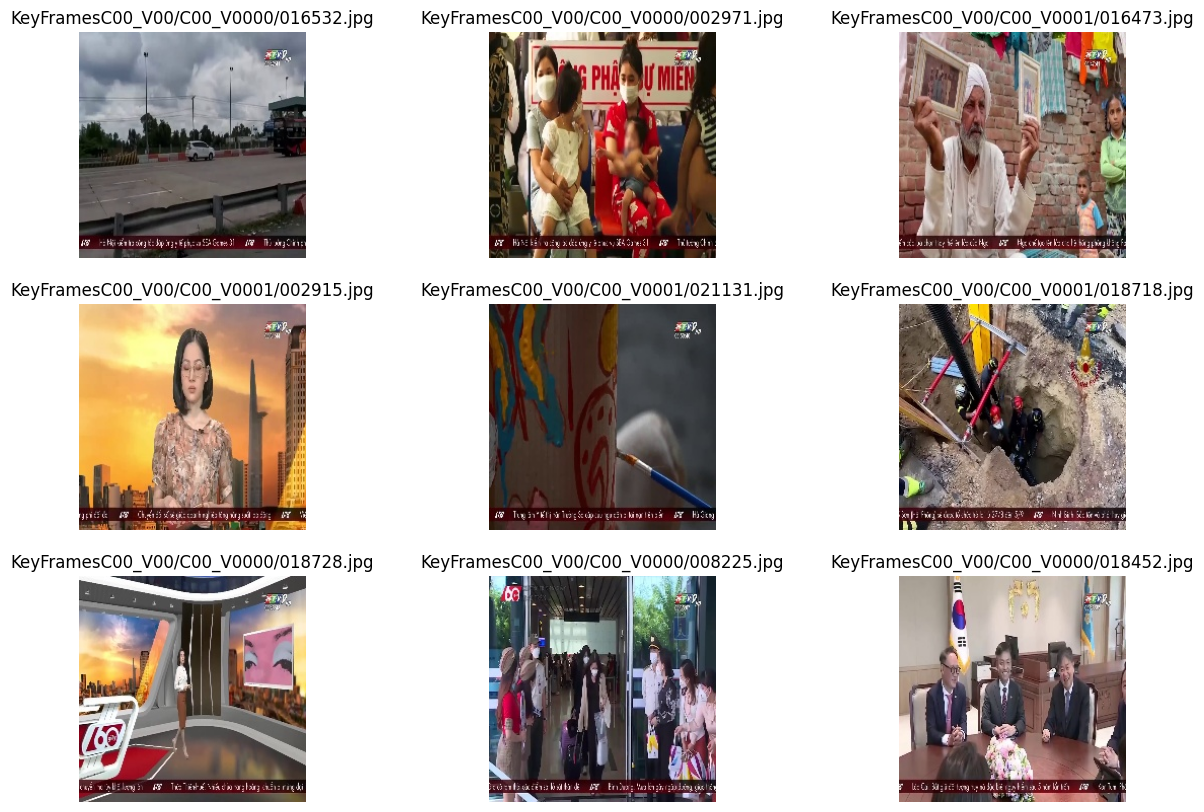

In [59]:
mybert = BERTSearch(dict_bert_search='data/OCR_ASR/keyframes_id_bert.json', bin_file='data/OCR_ASR/faiss_bert_OCR_LIT.bin', mode='search')

text = 'hà nội kiểm tra công tác đáp ứng y tế '

scores, idx_image, infos_query, image_paths = mybert.bert_search(text, k=9)
mybert.show_images(image_paths)


⚠️ Reusing local copy: LiT-B16B.npz
Text translation:  Hanoi checks medical response
Time inference of search: 0.7512083053588867


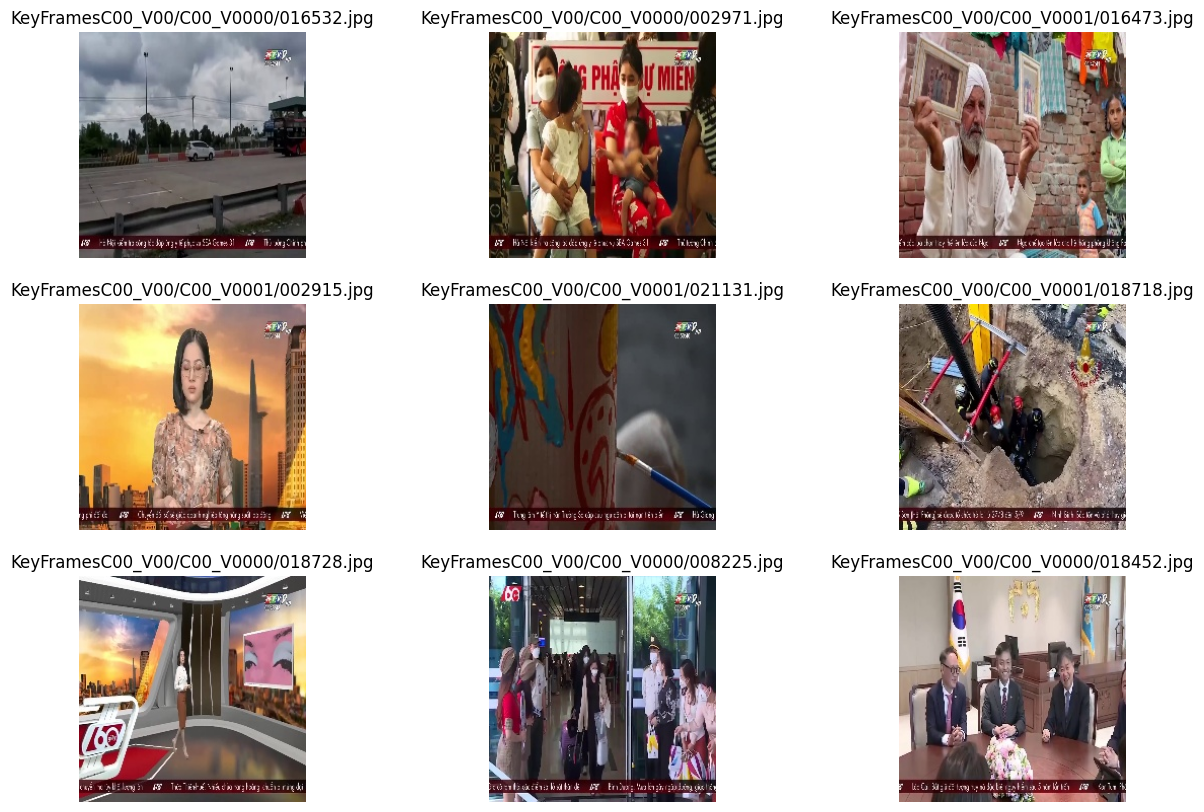

In [60]:
from utils.translate_processing import Translation
from vit_jax import models
import time
import os
import json
import matplotlib.pyplot as plt
from langdetect import detect
import numpy as np
import faiss
import math


def time_complexity(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        results = func(*args, **kwargs)
        print('Time inference of {}: {}'.format(args[0].mode, time.time() - start))
        return results
    return wrapper


class FaissSearch(Translation):
    def __init__(self, dict_bert_search = 'data/OCR_ASR/keyframes_id_bert.json', bin_file = 'data/OCR_ASR/faiss_beart_LIT.bin', mode = 'write', model = "lit"):
        self.mode = mode
        self.index = self.load_bin_file(bin_file)
        self.id2img_fps = self.load_json_file(dict_bert_search)
        if model == "lit":
            os.system('TF_CPP_MIN_LOG_LEVEL=0')
            self.lit_model = models.get_model("LiT-B16B")
            self.lit_var = self.lit_model.load_variables()
            self.tokenizer = self.lit_model.get_tokenizer()
            self.translate = Translation()
        else:
            pass
    def load_bin_file(self, bin_file: str):
        return faiss.read_index(bin_file)
    def load_json_file(self, json_bath: str):
        with open(json_bath, "r") as f:
            js = json.loads(f.read())
        return {int(k): v for k, v in js.items()}
    
    def show_images(self, image_paths):
        fig = plt.figure(figsize=(15, 10))
        columns = int(math.sqrt(len(image_paths)))
        rows = int(np.ceil(len(image_paths)/columns))

        for i in range(1, columns*rows +1):
            img = plt.imread(image_paths[i - 1])
            ax = fig.add_subplot(rows, columns, i)
            ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

            plt.imshow(img)
            plt.axis("off")

        plt.show()

    @time_complexity
    def text_search(self, text, k):
        if detect(text) == "vi":
            text = self.translate(text)
            print("Text translation: ", text)
            tokens = self.tokenizer([text])
            _, text_features, _ = self.lit_model.apply(self.lit_var, tokens=tokens)
            scores, idx_image = self.index.search(np.array(text_features), k=k)
            idx_image = idx_image.flatten()
            infos_query = list(map(self.id2img_fps.get, list(idx_image)))
            image_paths =  [os.path.join(info['video_path'],f"{info['list_shot_id'][0]}.jpg") for info in infos_query]
            return scores, idx_image, infos_query, image_paths


def main():
    faiss_search = FaissSearch(dict_bert_search='data/OCR_ASR/keyframes_id_bert.json', bin_file='data/OCR_ASR/faiss_bert_OCR_LIT.bin', mode='search')
    text = "hà nội kiểm tra công tác đáp ứng y tế "
    scores, idx_image, infos_query, image_paths = faiss_search.text_search(text, k=9)
    faiss_search.show_images(image_paths)

    
if __name__ == "__main__":
    main()